In [1]:
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
import re
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
import string
from wordcloud import STOPWORDS

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.stats import gaussian_kde


## Chargement Dataset

In [2]:
df = pd.read_csv("../data/train_tweets.csv")


## Apercu des valeurs 

In [3]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
nb_uniques = df["keyword"].nunique()  # nombre de mots-clés uniques (≠ valeurs nulles)
nb_non_nulls = df["keyword"].notnull().sum()  # cellules non vides
pourcentage_remplis = nb_non_nulls / len(df) * 100

print("Nombre de mots clés uniques :", nb_uniques)
print(f"Pourcentage de cellules remplies : {pourcentage_remplis:.2f}%")


Nombre de mots clés uniques : 221
Pourcentage de cellules remplies : 99.20%


In [6]:
nb_uniques = df["location"].nunique()  # nombre de mots-clés uniques (≠ valeurs nulles)
nb_non_nulls = df["location"].notnull().sum()  # cellules non vides
pourcentage_remplis = nb_non_nulls / len(df) * 100

print("Nombre de mots location uniques :", nb_uniques)
print(f"Pourcentage de cellules remplies : {pourcentage_remplis:.2f}%")


Nombre de mots location uniques : 3341
Pourcentage de cellules remplies : 66.73%


In [7]:
print(df.shape)

(7613, 5)


In [8]:
df.dropna(inplace=True)

## EDA sur données bruts


Cette EDA est faite sur les textes bruts pour identifier les patterns initiaux. Le nettoyage sera fait dans un second temps.

In [9]:
df_0 = df[df['target'] == 0]
df_1 = df[df['target'] == 1]

In [10]:
# Fonction pour obtenir les mots les plus fréquents
def get_top_words(series, n=10):
    words = " ".join(series).lower().split()
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]
    return Counter(words).most_common(n)


# Extraction des top mots
top_words_0 = get_top_words(df_0["keyword"], 50)
top_words_1 = get_top_words(df_1["keyword"], 50)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Keyword (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Keyword (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Keyword (Non-catastrophe),Fréquence,Keyword (Catastrophe),Fréquence
0,armageddon,28,outbreak,30
1,ruin,27,wreckage,28
2,harm,26,oil%20spill,27
3,aftershock,25,collision,26
4,bloody,25,buildings%20on%20fire,25
5,fear,25,derailment,25
6,screaming,25,evacuated,25
7,upheaval,25,airplane%20accident,24
8,blight,24,earthquake,24
9,deluge,24,sandstorm,24


In [11]:
# Extraction des top mots
top_words_0 = get_top_words(df_0["location"], 50)
top_words_1 = get_top_words(df_1["location"], 50)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Location (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Location (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Location (Non-catastrophe),Fréquence,Location (Catastrophe),Fréquence
0,new,129,usa,126
1,usa,124,new,80
2,ca,86,ca,57
3,york,77,united,44
4,london,52,nigeria,42
5,united,51,canada,41
6,uk,49,uk,40
7,ny,46,india,34
8,england,44,san,33
9,canada,43,states,33


In [12]:
# Extraction des top mots
top_words_0 = get_top_words(df_0["text"], 50)
top_words_1 = get_top_words(df_1["text"], 50)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Mot (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Mot (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Mot (Non-catastrophe),Fréquence,Mot (Catastrophe),Fréquence
0,-,259,-,244
1,like,165,&amp;,74
2,just,154,police,72
3,i'm,141,like,65
4,new,127,just,61
5,&amp;,119,killed,60
6,??,115,families,59
7,it's,79,people,57
8,don't,75,suicide,57
9,|,75,...,56


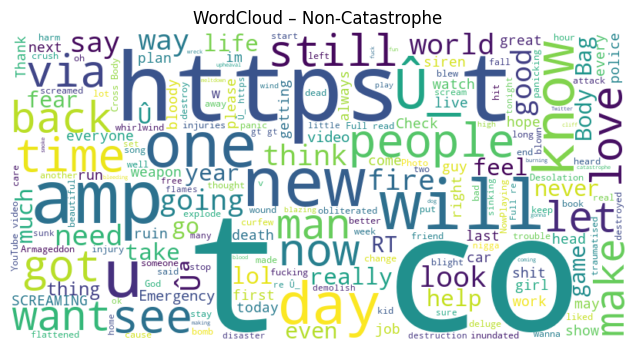

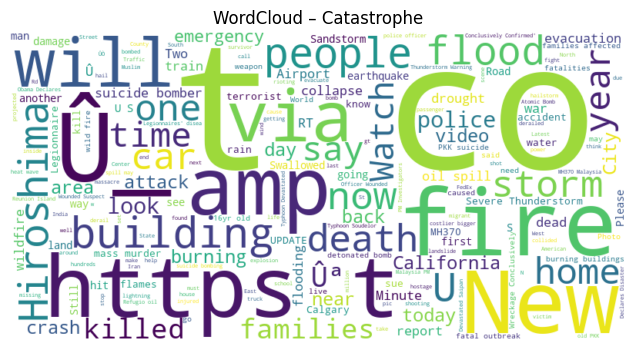

In [13]:
# Concaténer les textes par classe
text_0 = " ".join(df_0["text"])
text_1 = " ".join(df_1["text"])

# Générer les nuages de mots
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_1)

# Affichage du WordCloud pour target = 0
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Non-Catastrophe")
plt.show()

# Affichage du WordCloud pour target = 1
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Catastrophe")
plt.show()

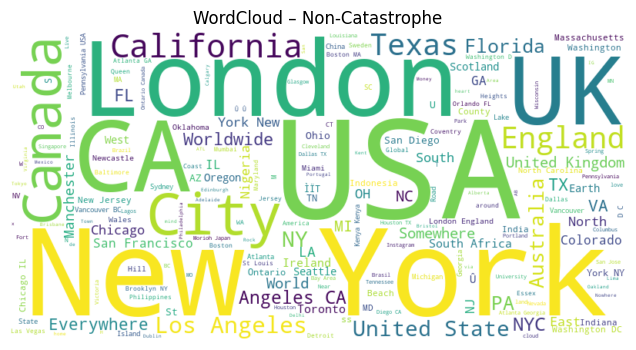

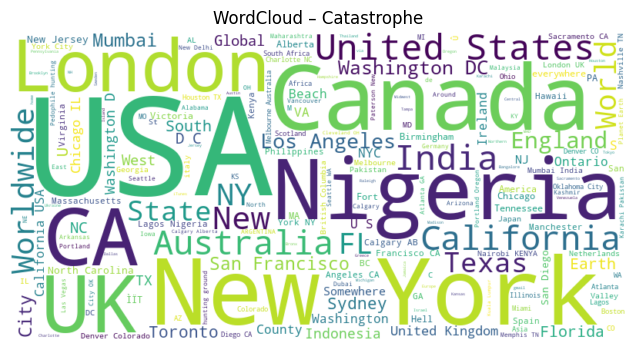

In [14]:
# Concaténer les textes par classe
text_0 = " ".join(df_0["location"])
text_1 = " ".join(df_1["location"])

# Générer les nuages de mots
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_1)

# Affichage du WordCloud pour target = 0
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Non-Catastrophe")
plt.show()

# Affichage du WordCloud pour target = 1
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Catastrophe")
plt.show()


## Ajout features

In [15]:
# Nombre de caractères par tweet
df['char_count'] = df['text'].apply(len)

# Nombre de mots par tweet
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Nb de stop-words
df["stopword_count"] = df["text"].apply(
    lambda x: sum(1 for w in x.lower().split() if w in ENGLISH_STOP_WORDS)
)



In [16]:
# Nombre total de mots dans chaque tweet
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Nombre de mots uniques dans chaque tweet
df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))

# Nombre de stopwords (mots vides comme 'le', 'et', 'mais'...) dans chaque tweet
df['stop_word_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# Nombre de liens URL présents dans chaque tweet
df['url_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# Longueur moyenne des mots dans chaque tweet
df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# Nombre total de caractères (lettres, espaces, ponctuations...) dans chaque tweet
df['char_count'] = df['text'].apply(lambda x: len(str(x)))

# Nombre de signes de ponctuation dans chaque tweet
df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Nombre de hashtags (#) dans chaque tweet
df['hashtag_count'] = df['text'].apply(lambda x: str(x).count('#'))

# Nombre de mentions (@) dans chaque tweet
df['mention_count'] = df['text'].apply(lambda x: str(x).count('@'))


## Analyse des features

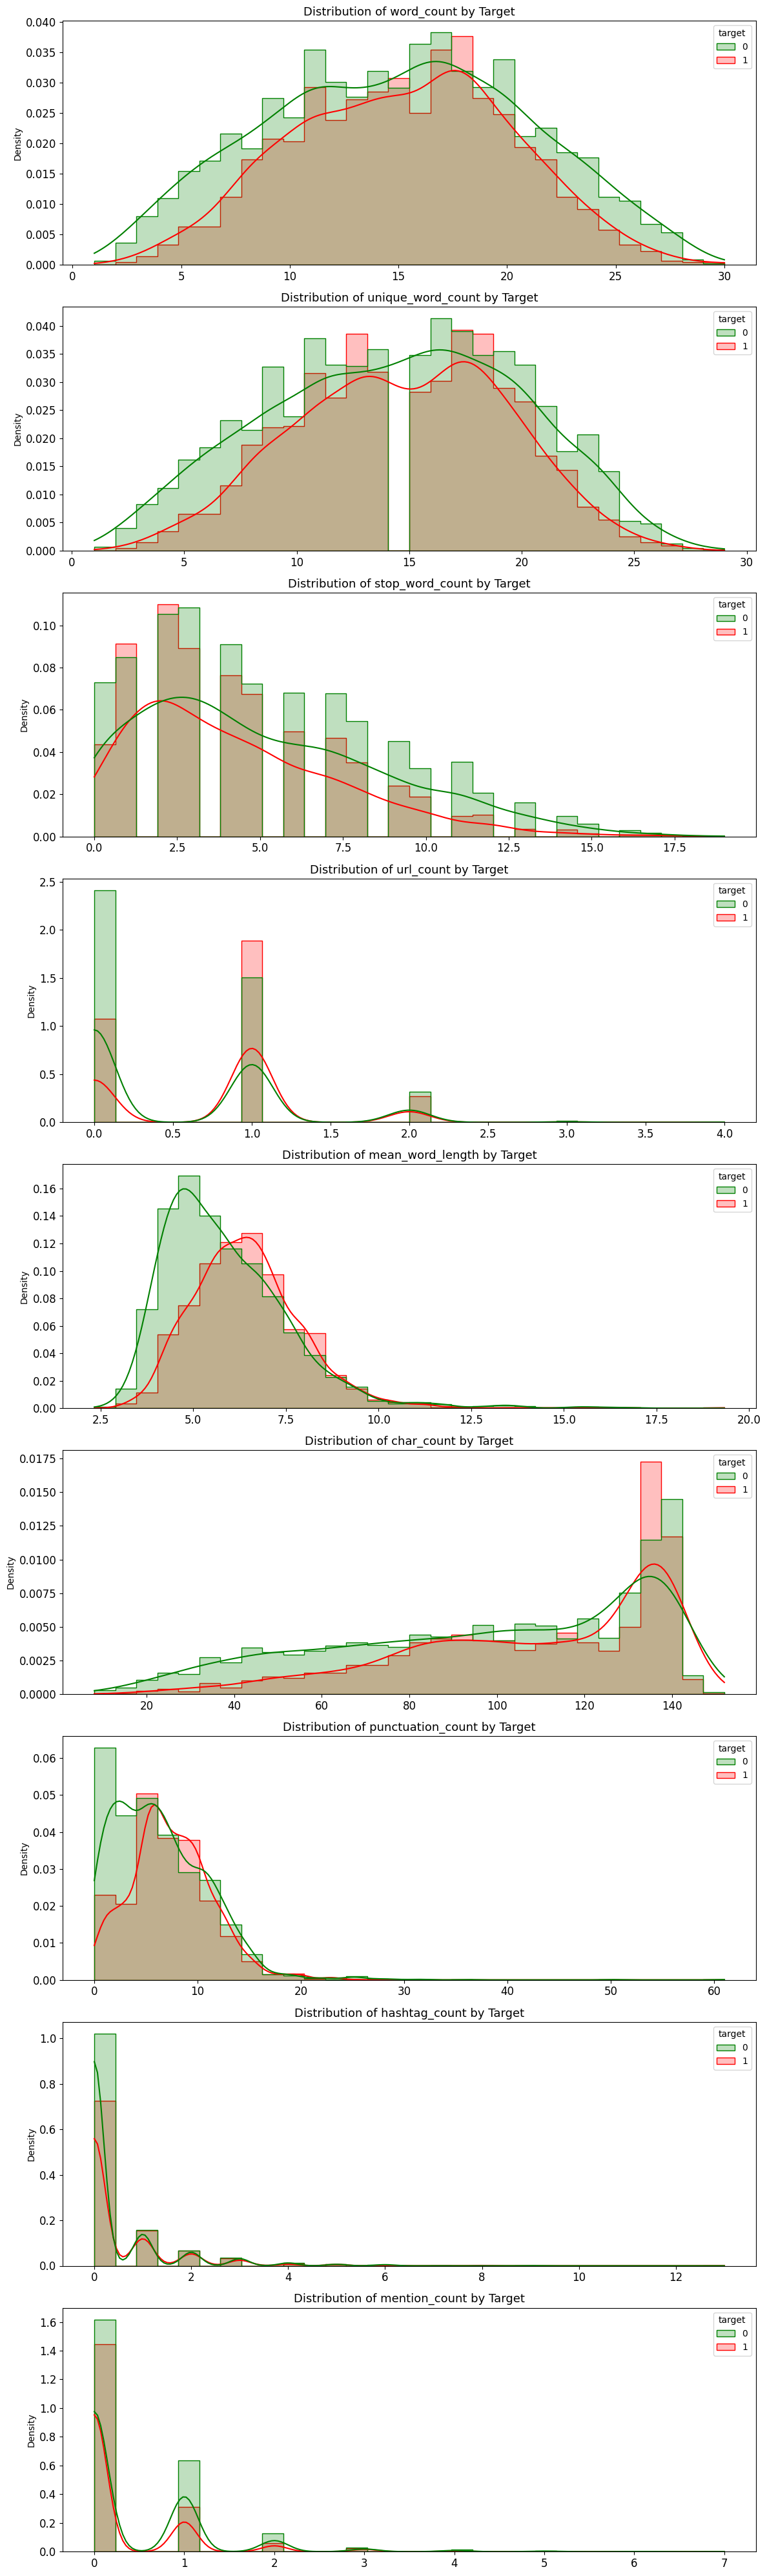

In [17]:
# Liste des features à analyser
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count',
                'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

# Filtre pour les tweets liés à des catastrophes
DISASTER_TWEETS = df['target'] == 1

# Création de la figure avec sous-graphiques
fig, axes = plt.subplots(nrows=len(METAFEATURES), ncols=1, figsize=(12, 40), dpi=100)

# Pour chaque feature, on trace deux courbes : disaster vs non-disaster
for i, feature in enumerate(METAFEATURES):
    sns.histplot(data=df, x=feature, hue='target', kde=True, ax=axes[i], bins=30,
                 palette={0: "green", 1: "red"}, element="step", stat="density")
    
    axes[i].set_title(f'Distribution of {feature} by Target', fontsize=13)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, ngram_range=(1, 1), top_n=20):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range)
    X = vec.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    word_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    sorted_words = sorted(word_freq, key=lambda x: x[1], reverse=True)
    return pd.DataFrame(sorted_words[:top_n], columns=['ngram', 'count'])

In [19]:
def plot_all_ngrams(df, target_value):
    text_data = df[df['target'] == target_value]['text']

    bigrams = get_top_ngrams(text_data, ngram_range=(2, 2), top_n=20)
    trigrams = get_top_ngrams(text_data, ngram_range=(3, 3), top_n=20)
    quadgrams = get_top_ngrams(text_data, ngram_range=(4, 4), top_n=20)

    fig, axes = plt.subplots(1, 3, figsize=(22, 10))

    for ax, data, title in zip(
        axes,
        [bigrams, trigrams, quadgrams],
        ['Bigrammes', 'Trigrammes', 'Quadgrammes']
    ):
        ngram_df = pd.DataFrame(data, columns=['ngram', 'count'])
        sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
        ax.set_title(f"{title} pour target = {target_value}")
        ax.set_xlabel("Fréquence")
        ax.set_ylabel("")

    plt.tight_layout()
    plt.show()


/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10243/4163899400.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10243/4163899400.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10243/4163899400.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_d

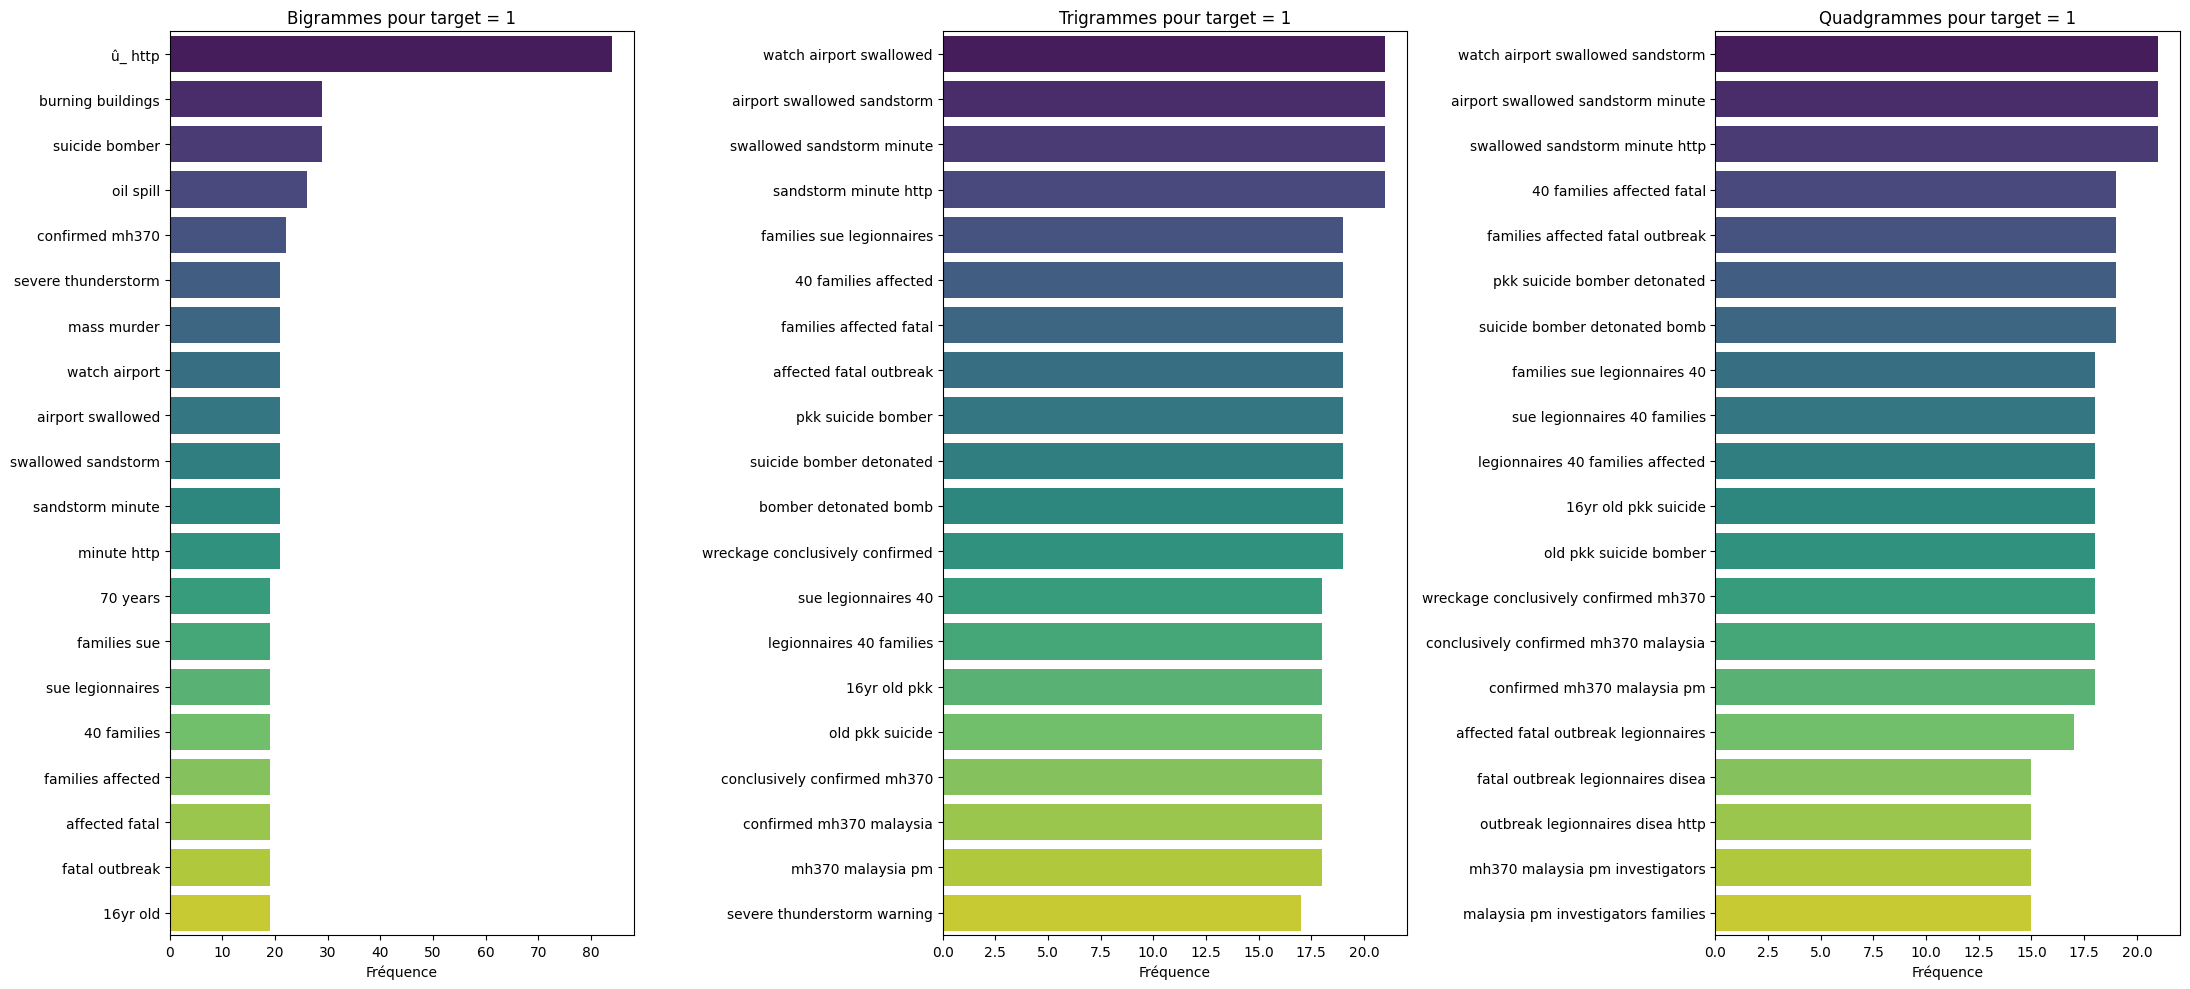

/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10243/4163899400.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10243/4163899400.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10243/4163899400.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_d

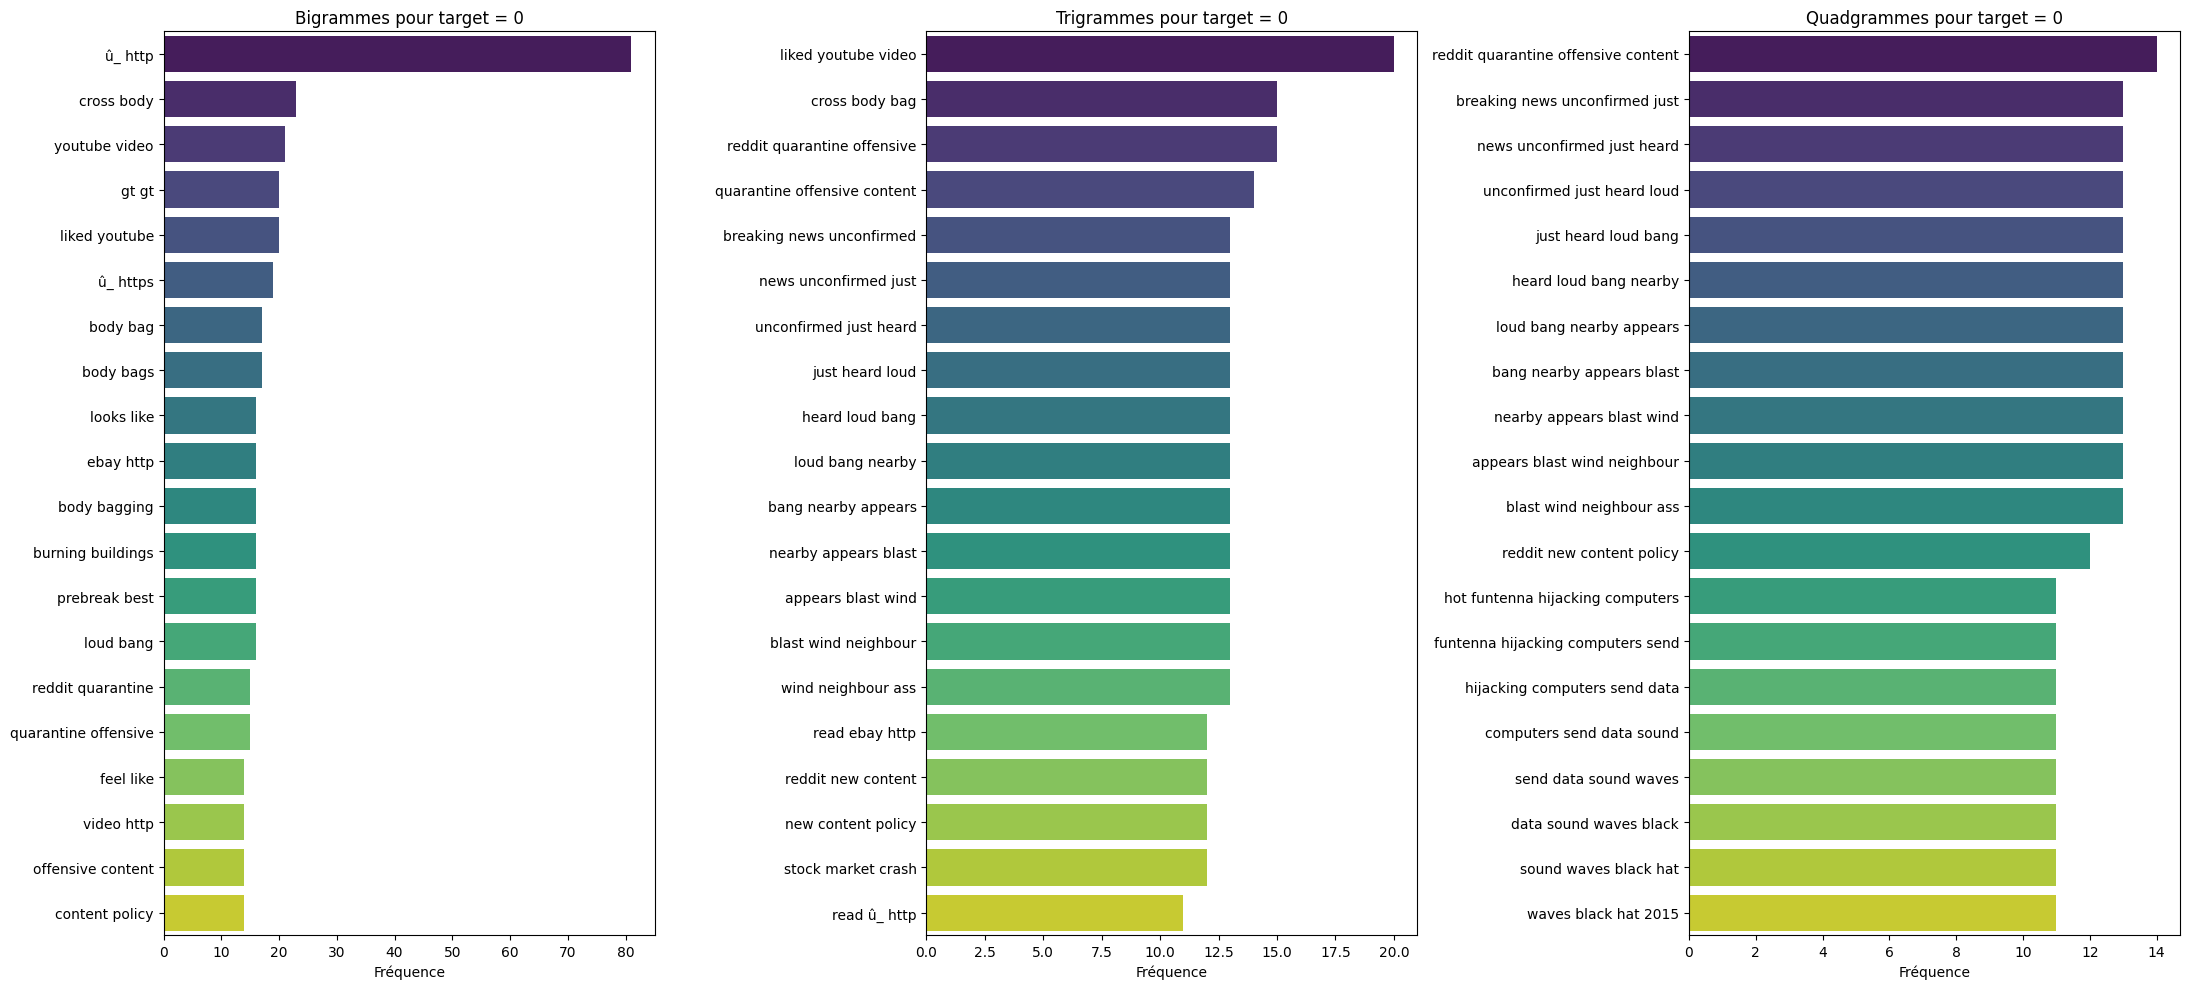

In [20]:
plot_all_ngrams(df, 1)  # Pour les tweets de catastrophe
plot_all_ngrams(df, 0)  # Pour les autres


In [21]:
df.to_pickle("df.pkl")
